In [ ]:
#!pip install tensorflow-addons==0.8.3
!pip install tensorflow-addons==0.9.1
!pip install tensorflow==2.2.0-rc3

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.experimental.AUTOTUNE

from tensorflow import keras
keras.__version__
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical

from random import random
from numpy.random import randint
from numpy import asarray

import sys

In [ ]:
# Load the vangogh-photo dataset using tensorflow-datasets.
dataset, _ = tfds.load("cycle_gan/vangogh2photo", with_info=True, as_supervised=True)
dataset2, _= tfds.load("cycle_gan/cezanne2photo", with_info=True, as_supervised=True)
dataset3, _= tfds.load("cycle_gan/monet2photo", with_info=True, as_supervised=True)
dataset4, _= tfds.load("cycle_gan/ukiyoe2photo", with_info=True, as_supervised=True)

train_painter1, train_photo = ([dataset["trainA"], 'vangogh'], [dataset2["trainA"], 'cezanne'], [dataset3["trainA"], 'monet'], [dataset4["trainA"], 'ukiyoe']), dataset["trainB"]
test_painter1, test_photo = ([dataset["testA"], 'vangogh'], [dataset2["testA"], 'cezanne'], [dataset3["testA"], 'monet'], [dataset4["testA"], 'ukiyoe']), dataset["testB"]

# Define the standard image size.
orig_img_size = (143, 143)
# Size of the random crops to be used during training.
input_img_size = (128, 128, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img, label):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 128x128
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img, label):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

In [ ]:
# Apply the preprocessing operations to the training data
train_painter1[0][0] = (
    train_painter1[0][0].map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_painter1[1][0] = (
    train_painter1[1][0].map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_painter1[2][0] = (
    train_painter1[2][0].map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_painter1[3][0] = (
    train_painter1[3][0].map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_photo = (
    train_photo.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

# Apply the preprocessing operations to the test data
test_painter1[0][0] = (
    test_painter1[0][0].map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_painter1[1][0] = (
    test_painter1[1][0].map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_painter1[2][0] = (
    test_painter1[2][0].map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_painter1[3][0] = (
    test_painter1[3][0].map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_photo = (
    test_photo.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

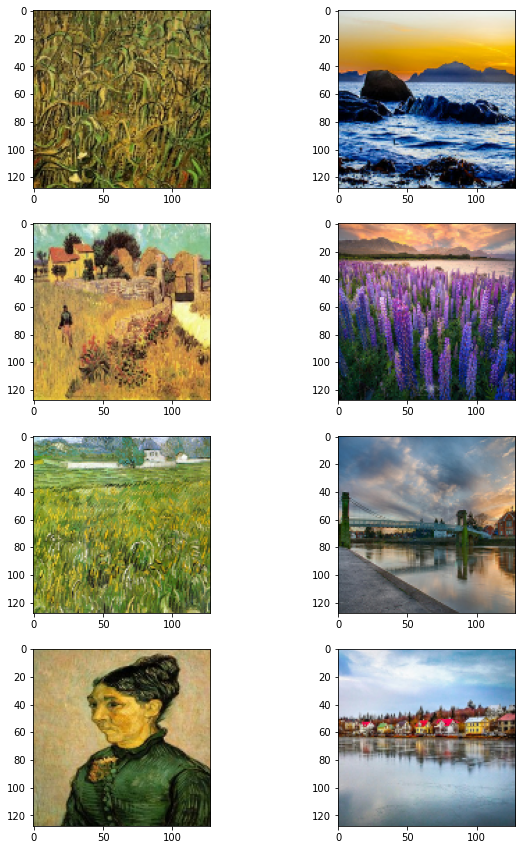

In [ ]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(train_painter1[0][0].take(4), train_photo.take(4))):
    vangogh = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    photo = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(vangogh)
    ax[i, 1].imshow(photo)
plt.show()

In [ ]:
ng = 64
nd = 64
no_of_styles = 4

In [ ]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor."""
    

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")

In [ ]:
from tensorflow.keras.layers import ReLU, Input, BatchNormalization, Lambda, Conv2DTranspose
from tensorflow.keras.activations import tanh

class Generator(layers.Layer):
  def __init__(self, no_of_styles = 4, ng = 64):
    super(Generator, self).__init__()
    self.encoder = encoder(ng)
    self.transformer = transformer(no_of_styles, ng)
    self.decoder = decoder(ng)

  def __call__(self, content, label):
    e = self.encoder(content, label)
    t = self.transformer(e)
    d = self.decoder(t)
    return d


class encoder(layers.Layer):
  def __init__(self, ng):
    super(encoder, self).__init__()

    self.model = keras.Sequential(
    [
        ReflectionPadding2D(padding=(3,3)),
        layers.Conv2D(ng, kernel_size=(7, 7), kernel_initializer=kernel_init),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init), #instance normalization
        ReLU(),

        #effectively downsampling here
        layers.Conv2D(ng * 2, kernel_size=(3, 3), kernel_initializer=kernel_init, strides=2, padding ="same"),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init), #instance normalization
        ReLU(),


        layers.Conv2D(ng * 4, kernel_size=(3, 3), kernel_initializer=kernel_init, strides=2, padding ="same"),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init), #instance normalization
        ReLU()
    ])

  def __call__(self, content, label):
    return [self.model(content), label]


class resnet_block(layers.Layer):
  def __init__(self, in_features):
    super(resnet_block, self).__init__()

    self.model = keras.Sequential(
    [
        ReflectionPadding2D(),
        layers.Conv2D(in_features, (3,3), (1,1), kernel_initializer=kernel_init, padding = "valid"),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init),
        ReLU(),
     
        ReflectionPadding2D(),
        layers.Conv2D(in_features, (3,3), (1,1), kernel_initializer=kernel_init, padding = "valid"),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)                                 
    ])
  

  def __call__(self, x):
    return self.model(x)

class transformer(layers.Layer):
  def __init__(self, no_of_styles, ng):
    super(transformer, self).__init__()
    self.no_of_styles = no_of_styles
    self.ng = ng

    self.t1 = resnet_block(ng * 4)
    self.t2 = resnet_block(ng * 4)
    self.t3 = resnet_block(ng * 4)
    self.t4 = resnet_block(ng * 4)

    self.t = [self.t1, self.t2, self.t3, self.t4]

  def __call__(self, x):
    label = x[1]
    content = x[0]

    a = self.t[0](content)
    b = self.t[1](content)
    c = self.t[2](content)
    d = self.t[3](content)

    if(label == 1):
      gen = a
    elif(label == 2):
      gen = b
    elif(label == 3):
      gen = c
    else:
      gen = d

    return gen


class decoder(layers.Layer):
  def __init__(self, ng):
    super(decoder, self).__init__()
    in_f = ng * 4
    op_f = in_f//2

    self.model = keras.Sequential(
    [
        resnet_block(in_f),
        resnet_block(in_f),
        resnet_block(in_f),
        resnet_block(in_f),
        resnet_block(in_f),
     
        Conv2DTranspose(op_f, (3, 3), kernel_initializer=kernel_init, strides=2, padding ="same"),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init),
        ReLU(),
     
        Conv2DTranspose(op_f//2, (3, 3), kernel_initializer=kernel_init, strides=2, padding ="same"),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init),
        ReLU(),
     
        ReflectionPadding2D(padding=(3,3)),
        layers.Conv2D(3, (7, 7), kernel_initializer=kernel_init, padding ="valid", activation ="tanh")
    ])

  def __call__(self, x):
    return self.model(x)

In [ ]:
from tensorflow.keras.layers import LeakyReLU

class Discriminator(layers.Layer):
  def __init__(self, nd=64, no_of_styles=4):
    super(Discriminator, self).__init__()

    op_f = nd

    self.model = keras.Sequential(
    [
        layers.Conv2D(op_f, kernel_size=(4, 4), kernel_initializer=kernel_init, strides=2, padding = "same"),
        LeakyReLU(alpha = 0.2),
     
        layers.Conv2D(op_f * 2, kernel_size=(4, 4), kernel_initializer=kernel_init, strides=2, padding = "same"),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init),
        LeakyReLU(alpha = 0.2),
     
        layers.Conv2D(op_f * 4, kernel_size=(4, 4), kernel_initializer=kernel_init, strides=2, padding = "same"),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init),
        LeakyReLU(alpha = 0.2),
     
        layers.Conv2D(op_f * 8, kernel_size=(4, 4), kernel_initializer=kernel_init, strides=2, padding = "same"),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init),
        LeakyReLU(alpha = 0.2)
    ])

    self.discriminator = layers.Conv2D(1, kernel_size=(4, 4), kernel_initializer=kernel_init, padding = "same")
    self.aux_clf = layers.Conv2D(no_of_styles, kernel_size=(4, 4), kernel_initializer=kernel_init, padding = "same")

  def __call__(self, x):
    base = self.model(x)
    discrim = self.discriminator(base)
    clf = self.aux_clf(base)
    clf = tf.transpose(clf)

    return [discrim, clf]

In [ ]:
class ReplayBuffer():
  def __init__(self, max_size=50):
    assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
    self.max_size = max_size
    self.data = []

  def update_image_pool(self, images, max_size=50):
    selected = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    for image in images:
      if len(self.data) < max_size:
        # stock the pool
        self.data.append(image)
        selected.write(0, image)
      elif random() < 0.5:
        # use image, but don't add it to the pool
        selected.write(0, image)
      else:
        # replace an existing image and use replaced image
        ix = randint(0, len(self.data))
        selected.write(0, self.data[ix])
        self.data[ix] = image
    return selected.stack()

In [ ]:
generator = Generator()
discriminator = Discriminator()

fake_buffer = ReplayBuffer()

In [ ]:
#Losses Init
tv_strength = 1e-6
lambda_A = 10.0
ae_constrain = 10
    
criterion_GAN = tf.keras.losses.MeanSquaredError()    
criterion_ACGAN = tf.keras.losses.CategoricalCrossentropy()
criterion_Rec = tf.keras.losses.MeanAbsoluteError()

In [ ]:
def label2tensor(label,tensor):
    for i in range(label.shape[0]):
        tensor[i].assign(label[i])
    return tensor

In [ ]:
def createClassLabelB(D_AC_size_0, D_AC_size_1, D_AC_size_2):
  class_label_B = tf.Variable(np.empty((D_AC_size_0,D_AC_size_1,D_AC_size_2), dtype=np.float32))
  return class_label_B

In [ ]:
class GatedGan(keras.Model):
    def __init__(
        self,
        generator,
        discriminator,
        
    ):
        super(GatedGan, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.count = 0

    def compile(
        self,
        gen_optimizer,
        disc_optimizer,
        
    ):
        super(GatedGan, self).compile()
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        

    def train_step(self, batch_data):
        style_data = [None for _ in range(4)]

        #real_x = content image
        #style data = painter style image
        real_x, style_data[0], style_data[1], style_data[2], style_data[3] = batch_data

        D_A_size = discriminator(style_data[0])[0].shape  
        D_AC_size = discriminator(style_data[0])[1].shape

        if self.count == 0:
          self.class_label_B = createClassLabelB(D_AC_size[0], D_AC_size[1], D_AC_size[2])
          self.fake_label = tf.Variable(np.zeros((1,8,8,1)), dtype=np.float32)
          self.real_label = tf.Variable(np.full((1,8,8,1), .99), dtype=np.float32)     

        #support for this was not implemented but should be
        autoflag_OHE = 5
        
        for i, real_y in enumerate(style_data):
          with tf.GradientTape(persistent=True) as tape:
              #was one hot encoded in reference code but decided to implement differently
              style_OHE = i
              style_OHE2 = to_categorical(i, num_classes=no_of_styles)

              class_label = label2tensor(style_OHE2,self.class_label_B)

              #generate style transferred image
              fake_y = self.generator(real_x, style_OHE)

              #pool from the image buffer
              fake = fake_buffer.update_image_pool(fake_y)

              # Discriminator forward pass with sampled fake
              disc_out_gan, aux_clf = self.discriminator(fake)

              # Discriminator Fake loss (correctly identify generated images)
              errD_fake = criterion_GAN(disc_out_gan, self.fake_label)

              disc_out_style, aux_clf_r = self.discriminator(style_data[i])
              errD_real_ac = criterion_ACGAN(aux_clf_r,class_label)*lambda_A
              errD_real = criterion_GAN(disc_out_style, self.real_label)
              errD_real_total = errD_real + errD_real_ac
              errd_style = criterion_GAN(disc_out_style, self.fake_label)

              errD = (errD_real+errD_fake)/2.0

              disc_out_gan_y, aux_clf_y = discriminator(fake_y)
              err_gan = criterion_GAN(disc_out_gan_y, self.real_label)
              # Generator style class loss
              aux_clf_yt = tf.transpose(aux_clf_y)
              err_aux_clf = criterion_ACGAN(aux_clf_y, class_label)*lambda_A

              #total variation loss
              err_TV = tf.image.total_variation(fake_y)

              #total loss
              errG_tot = err_gan + err_TV + err_aux_clf
              identity = generator(real_x, autoflag_OHE)
              err_ae = criterion_Rec(identity,real_x)*ae_constrain
              
          #get gradients for generator
          gen_grads = tape.gradient(errG_tot, self.generator.trainable_variables)

          #get gradients for discriminator
          disc_grads = tape.gradient(errD, self.discriminator.trainable_variables)
          
          #update the weights of the generator
          self.gen_optimizer.apply_gradients(
              zip(gen_grads, self.generator.trainable_variables)
          )

          #update the weights of the discriminator
          self.disc_optimizer.apply_gradients(
              zip(disc_grads, self.discriminator.trainable_variables)
          )

        self.count += 1  

        return {
            "G_loss": errG_tot,
            "D_loss": errD,
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 5, figsize=(12, 12))
        for i, img in enumerate(test_photo.take(self.num_img)):
            prediction1 = self.model.gen_G(img, 1)[0].numpy()
            prediction2 = self.model.gen_G(img, 2)[0].numpy()
            prediction3 = self.model.gen_G(img, 3)[0].numpy()
            prediction4 = self.model.gen_G(img, 4)[0].numpy()

            prediction1 = (prediction1 * 127.5 + 127.5).astype(np.uint8)
            prediction2 = (prediction2 * 127.5 + 127.5).astype(np.uint8)
            prediction3 = (prediction3 * 127.5 + 127.5).astype(np.uint8)
            prediction4 = (prediction4 * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction1)
            ax[i, 2].imshow(prediction2)
            ax[i, 3].imshow(prediction3)
            ax[i, 4].imshow(prediction4)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image - Style 1")
            ax[i, 2].set_title("Translated image - Style 2")
            ax[i, 3].set_title("Translated image - Style 3")
            ax[i, 4].set_title("Translated image - Style 4")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction1 = keras.preprocessing.image.array_to_img(prediction1)
            prediction1.save(
                "generated_img1_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )

            prediction2 = keras.preprocessing.image.array_to_img(prediction2)
            prediction2.save(
                "generated_img2_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )

            prediction3 = keras.preprocessing.image.array_to_img(prediction3)
            prediction3.save(
                "generated_img3_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )

            prediction4 = keras.preprocessing.image.array_to_img(prediction4)
            prediction4.save(
                "generated_img4_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()

In [ ]:
# Create gated gan model
gated_gan_model = GatedGan(
    generator=generator, discriminator=discriminator
)

# Compile the model
gated_gan_model.compile(
    gen_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/gatedgan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath
)

# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
gated_gan_model.fit(
    tf.data.Dataset.zip((train_photo, train_painter1[0][0], train_painter1[1][0], train_painter1[2][0], train_painter1[3][0])),
    epochs=1,
    callbacks=[plotter, model_checkpoint_callback],
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


UnimplementedError: ignored